In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
%matplotlib inline

In [2]:
train = pd.read_csv("train_clean.csv")

In [3]:
test = pd.read_csv('test_clean.csv')

In [4]:
# GrLivArea outliers
train = train.drop(train[(train['GrLivArea']>8.3) & (train['SalePrice']<300000)].index)

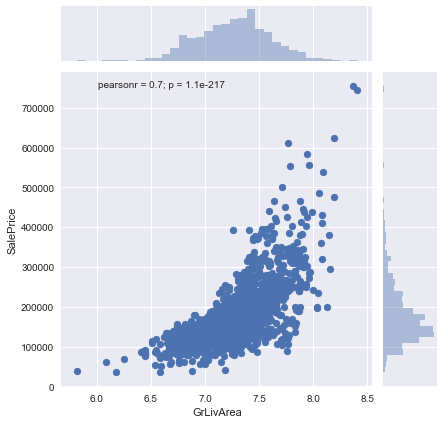

In [5]:
sns.jointplot(x ="GrLivArea", y="SalePrice", data=train)

In [6]:
from sklearn import preprocessing
from scipy.stats import boxcox

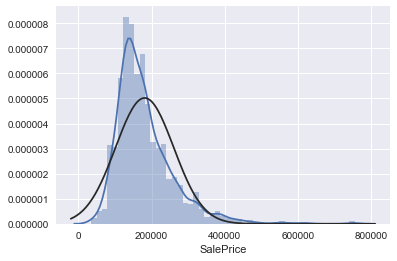

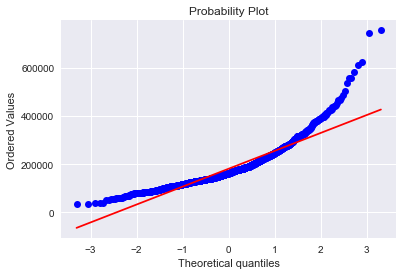

In [7]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [8]:
train["SalePrice"] = np.log1p(train["SalePrice"])

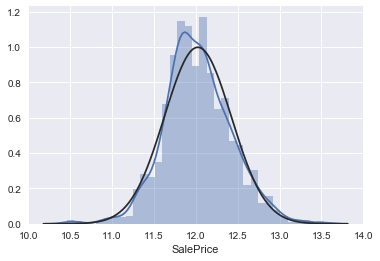

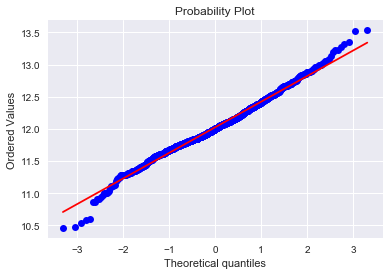

In [9]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [10]:
train['TotalSF'] = train['X1stFlrSF'] + train['X2ndFlrSF'] + train['TotalBsmtSF']
test['TotalSF'] = test['X1stFlrSF'] + test['X2ndFlrSF'] + test['TotalBsmtSF']

In [11]:
test.shape

(1459, 65)

In [12]:
train.shape

(1458, 66)

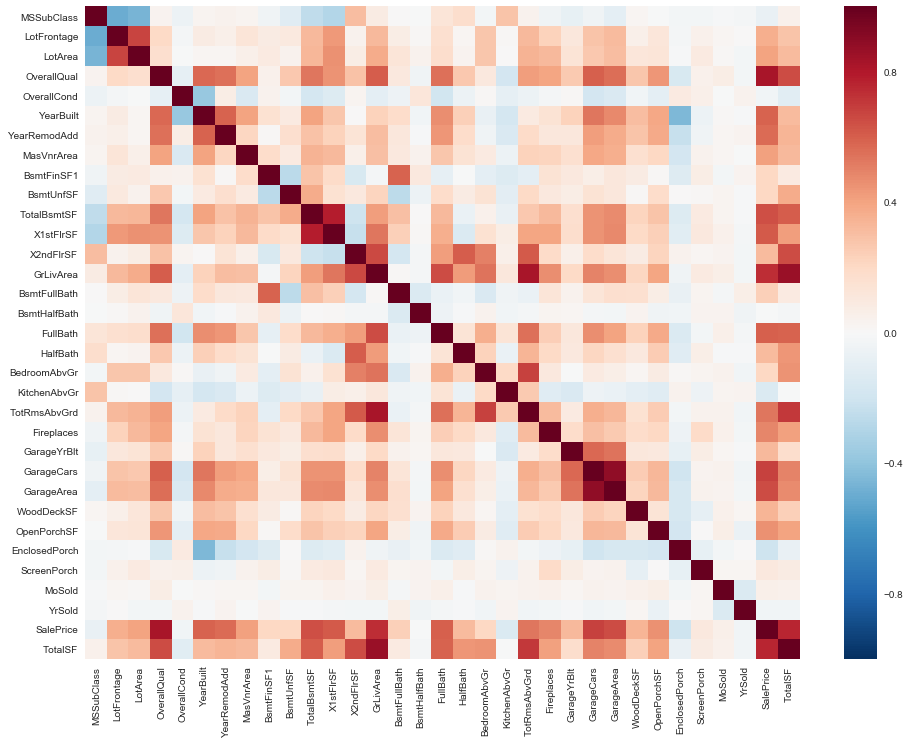

In [13]:
corr = train.corr()
ax = plt.subplots(figsize = (16,12))
sns.heatmap(corr)

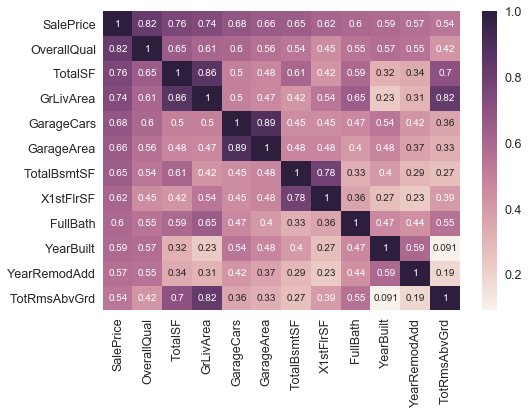

In [14]:
k = 12 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

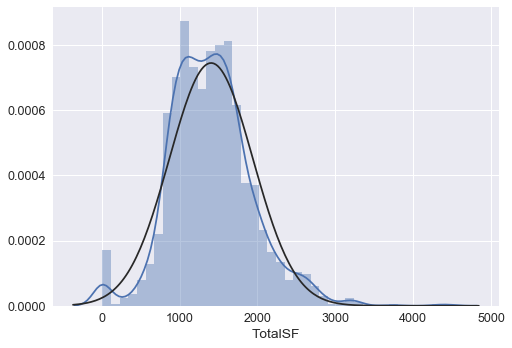

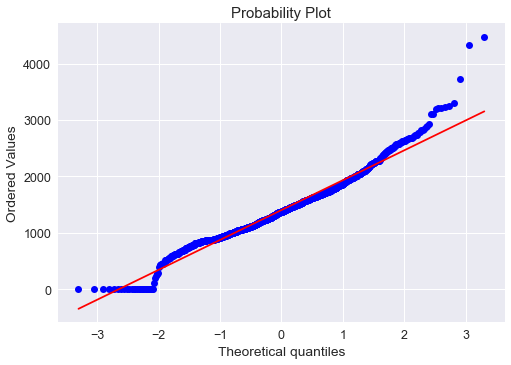

In [15]:
sns.distplot(train['TotalSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalSF'], plot=plt)

ok, removing the one outlier where the total SF is higher than 7000 square feet

In [16]:
train = train.drop(train[train['TotalSF']>7000].index)

now going to try boxcoxing this

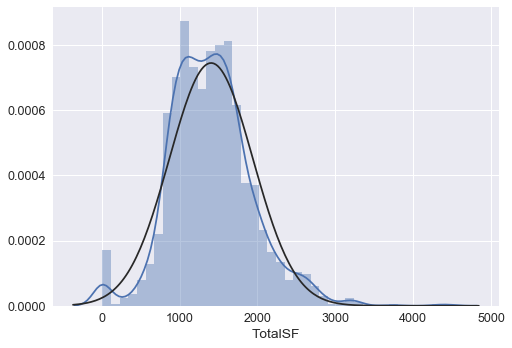

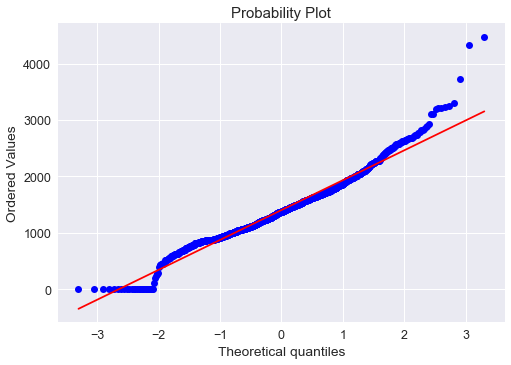

In [17]:
sns.distplot(train['TotalSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalSF'], plot=plt)

In [18]:
y_train = train.SalePrice.values

In [19]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("data size is : {}".format(data.shape))

data size is : (2917, 65)


In [20]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [21]:
data = pd.get_dummies(data, drop_first=True, dummy_na=True)

In [22]:
train = data[:ntrain]
test = data[ntrain:]

In [23]:
train.shape

(1458, 250)

In [24]:
test.shape

(1459, 250)

In [25]:
# Load libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [26]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [27]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00099, random_state=1))

In [28]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1142 (0.0062)


ok this one's a little worse than mine. but since this is what we decided i'll try working with it

In [29]:
lasso.fit(train.values, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.00099, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [30]:
final = lasso.predict(test)

In [31]:
final

array([ 11.66269523,  11.9597352 ,  12.11508538, ...,  12.04761483,
        11.7166688 ,  12.34814274])

In [32]:
results = np.expm1(lasso.predict(test))

In [33]:
results

array([ 116155.67817565,  156330.68238727,  182604.86668088, ...,
        170690.79307794,  122597.34439668,  230530.48845369])

In [34]:
# attempt3 = pd.DataFrame()
# attempt1['Id'] = test_ID
# attempt1['SalePrice'] = results
# attempt1.to_csv('submit3.csv', index=False)

In [38]:
train.describe()

,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,...,SaleCondition_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,...,1458.0,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.0
mean,2.866255,4.224311,0.423868,0.057613,5.647261,0.698976,0.611111,1.563786,472.050069,1.766118,...,0.0,0.002743,0.001372,0.006173,0.003429,0.003429,0.082305,0.002058,0.868999,0.0
std,0.816323,2.990471,0.517404,0.238907,1.855010,1.728308,0.641988,0.549891,212.239248,0.747104,...,0.0,0.052324,0.037024,0.078351,0.058480,0.058480,0.274922,0.045330,0.337518,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2.000000,0.000000,0.000000,0.000000,5.411646,0.000000,0.000000,1.000000,331.500000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,3.000000,5.948032,0.000000,0.000000,6.170651,0.000000,1.000000,2.000000,479.500000,2.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,3.000000,6.568075,1.000000,0.000000,6.695799,0.000000,1.000000,2.000000,576.000000,2.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
max,8.000000,7.691200,3.000000,2.000000,7.756623,6.315358,3.000000,3.000000,1390.000000,4.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
